# Explorando MedMNIST com PyTorch

Vamos seguir o _workflow_ padrão de _machine learning_ e _PyTorch_.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png)

**Objetivo:** trabalhar com alguns modelos de redes neurais em uma tarefa de classificação de imagens com a base MedMNIST.

**Base de Dados:** MedMNIST
* https://github.com/MedMNIST/MedMNIST/blob/main/README.md
* https://medmnist.com/

**Dataset selecionado** PneumoniaMNIST
- Número de classes: 2
- Rótulos: {'0': 'normal', '1': 'pneumonia'}
- Divisão dos dados: 
  *Treinamento: 4708 amostras 
  *Validação: 524 amostras 
  *Teste: 624 amostras

![](https://medmnist.com/assets/v2/imgs/PneumoniaMNIST.jpg)


## 1. Instalando o pacote MedMNIST para acessar a base de dados via PyTorch (compatível)

In [1]:
# Instalação da versão mais atual da base MedMNIST+ (inclui as opções 64x64, 128x128 e 224x224 para os casos 2D)
%pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git

  Cloning https://github.com/MedMNIST/MedMNIST.git to c:\users\levy\appdata\local\temp\pip-req-build-ytcmioyw
  Resolved https://github.com/MedMNIST/MedMNIST.git to commit 6e387a5597646e7038adff41175fae9f68f1dd3c
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/MedMNIST/MedMNIST.git 'C:\Users\Levy\AppData\Local\Temp\pip-req-build-ytcmioyw'


### 1.1. Selecionamos um _dataset_ específico da base MedMNIST e exibimos algumas informações básicas

**Escolha:** PneumoniaMNIST
- Imagens de raio-X do tórax para detecção de pneumonia


In [2]:
import medmnist
from medmnist import INFO, Evaluator

""" Classificação binária --> Imagens de raio-X para detecção de pneumonia -- """
data_flag = 'pneumoniamnist'
download = True

#A partir de um dicionário, recuperamos informações básicas do dataset escolhido
info = INFO[data_flag]

""" task = tipo de tarefa
    labels = dicionário que associa rótulos numéricos {0,1,...} ao nome das classes
    class_names = lista contendo os nomes das classes - obtida a partir do dicionário labels
    splits_info = dicionário que aponta a quantidade de amostras para cada partição dos dados  (train, val, test)
    n_classes = número de classes existentes """

task = info['task']
labels = info['label']
class_names = list(labels.values())
splits_info = info['n_samples']
n_classes = len(info['label'])

#Extrai o nome da classe referente ao dataset escolhido para, depois, baixar as amostras das diferentes partições
DataClass = getattr(medmnist, info['python_class'])

print(f"Dataset selecionado: {data_flag}")
print(f"Tarefa: {task}")
print(f"Número de classes: {n_classes}")
print(f"Classes disponíveis: {class_names}")
print(f"Rótulos: {labels}")
print(f"\nDivisão dos dados: \n Treinamento: {splits_info['train']} amostras \n Validação: {splits_info['val']} amostras \n Teste: {splits_info['test']} amostras")


Dataset selecionado: pneumoniamnist
Tarefa: binary-class
Número de classes: 2
Classes disponíveis: ['normal', 'pneumonia']
Rótulos: {'0': 'normal', '1': 'pneumonia'}

Divisão dos dados: 
 Treinamento: 4708 amostras 
 Validação: 524 amostras 
 Teste: 624 amostras


### 1.2. Baixamos as amostras do _dataset_ escolhido

In [3]:
import torch
from pathlib import Path
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchmetrics
from torchmetrics import ConfusionMatrix, Accuracy, F1Score
from torchmetrics.classification import BinaryROC
from mlxtend.plotting import plot_confusion_matrix

""" Define as transformações a serem aplicadas nos dados """
data_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[.5], std=[.5])
])

#Carrega os subconjuntos já como torch.Tensor
train_data = DataClass(split='train', transform=data_transform, size=64, download=download)
val_data = DataClass(split='val', transform=data_transform, size=64, download=download)
test_data = DataClass(split='test', transform=data_transform, size=64, download=download)

""" Verificando os tamanhos das partições """
print(f"Treinamento: {len(train_data)}")
print(f"Validação: {len(val_data)}")
print(f"Teste: {len(test_data)}")


Using downloaded and verified file: C:\Users\Levy\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\Levy\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\Levy\.medmnist\pneumoniamnist_64.npz
Treinamento: 4708
Validação: 524
Teste: 624


In [33]:
from typing import Dict,List

""" Função que computa a quantidade de amostras de cada classe - CASO BINÁRIO """
def check_class_balance(dataset: medmnist.dataset,
                        class_names: List) -> Dict[str, List[float]]:
    
    #extrai a sequência de rótulos numéricos do dataset
    lbl = np.unique(dataset.labels)  

    #inicializa um dicionário vazio
    dict = {}  

    #quantidade de amostras da classe positiva (num. de rótulos = 1)
    for i in range(len(lbl)):
        
        #conta as ocorrências do rótulo i = {0, 1, ...} no array de labels do dataset
        ci = np.count_nonzero(dataset.labels == i)

        #acrescenta ao dicionário o nome da i-ésima classe junto da contagem de amostras dessa classe no dataset
        dict[class_names[i]] = ci

    return dict

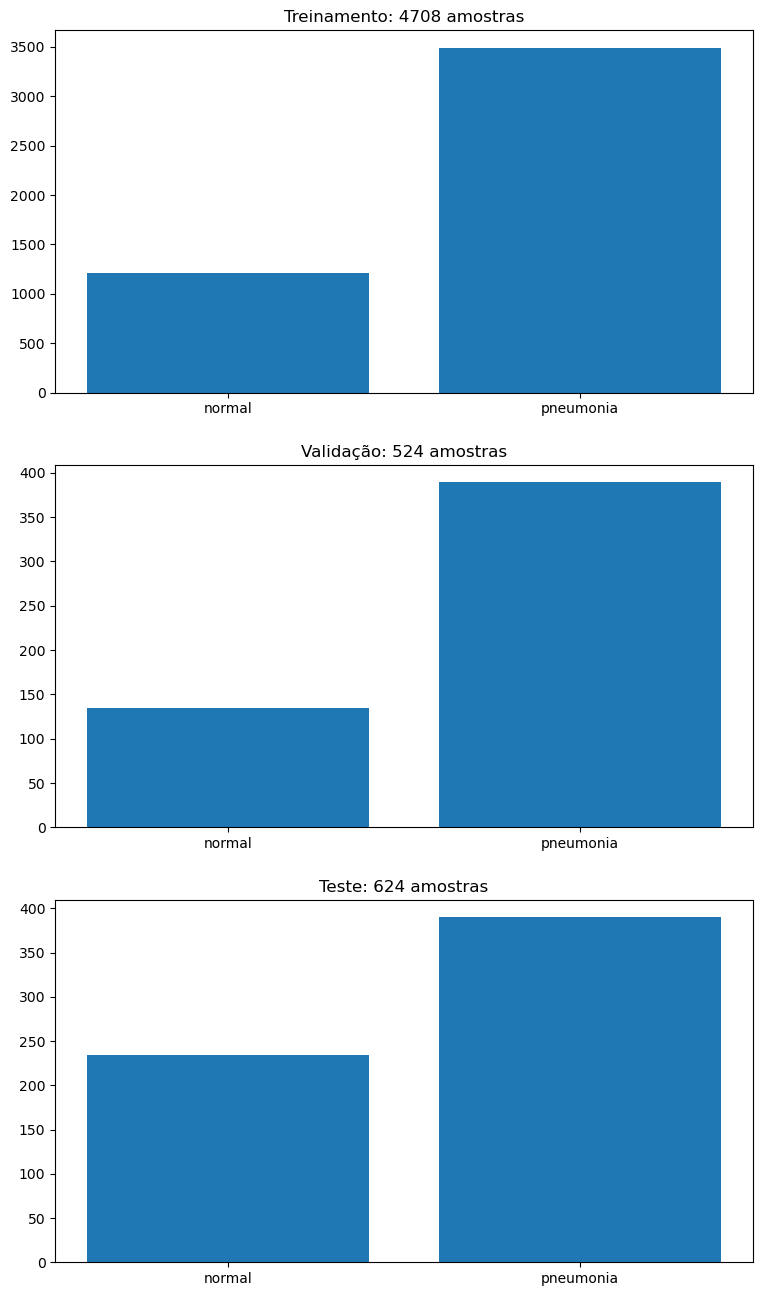

In [34]:
""" Verificando o balanceamento das classes nos conjuntos de treinamento, validação e teste """
fig = plt.figure(figsize=(9, 16))

fig.add_subplot(3,1,1)
dict_classes = check_class_balance(train_data,class_names)

plt.bar(x=dict_classes.keys(),height=dict_classes.values())
plt.title(f"Treinamento: {len(train_data)} amostras")

fig.add_subplot(3,1,2)
dict_classes = check_class_balance(val_data,class_names)
plt.bar(x=dict_classes.keys(),height=dict_classes.values())
plt.title(f"Validação: {len(val_data)} amostras")

fig.add_subplot(3,1,3)
dict_classes = check_class_balance(test_data,class_names)
plt.bar(x=dict_classes.keys(),height=dict_classes.values())
plt.title(f"Teste: {len(test_data)} amostras")

plt.show()   

### 1.3. Visualizando algumas amostras e suas características

**Nota:** o rótulo (label) de cada imagem vem no formato `int32`. Para buscarmos o nome da classe podemos usar o dicionário; contudo, precisamos converter esse número (sem ser um array, apenas um número mesmo) em `string`.

Solução:
```python 
str(label.item())
```


Shape/Formato de uma amostra: torch.Size([1, 64, 64]) - (channels, height, width)


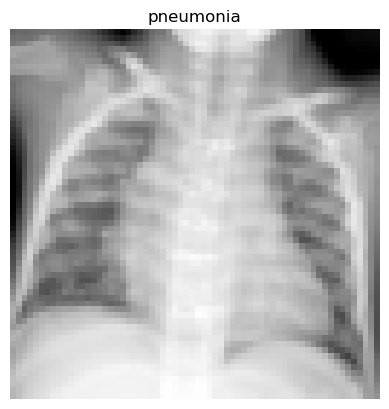

In [36]:
#Pegamos a primeira amostra do conjunto de treinamento
image,label = train_data[0]
print(f"Shape/Formato de uma amostra: {image.shape} - (channels, height, width)")

plt.imshow(image.squeeze(),cmap="gray") # image shape = [1, 64, 64] (colour channels, height, width)
plt.title(labels[str(label.item())])
plt.axis(False);


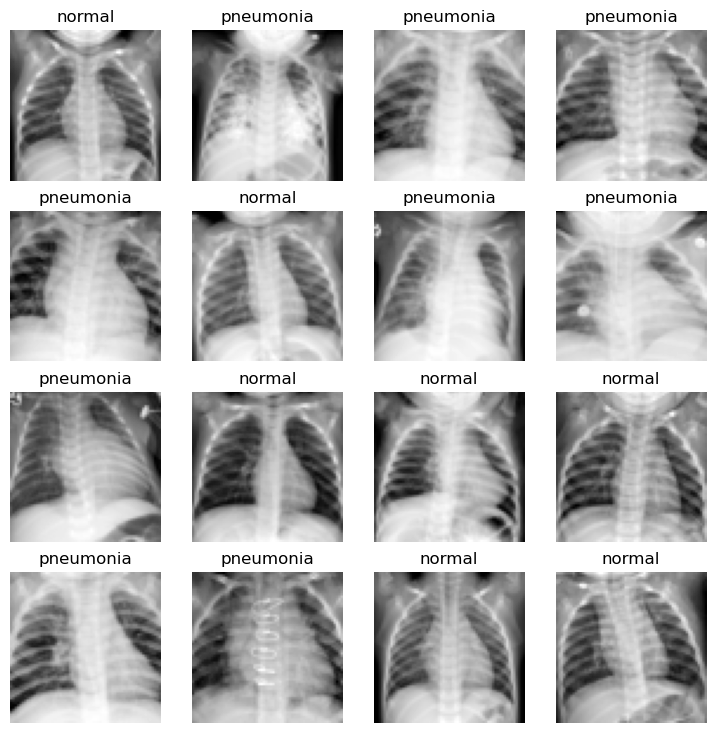

In [37]:
# Vamos exibir 16 figuras aleatórias da base de dados
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(0,rows*cols):

    #sorteia um índice de amostra aleatoriamente
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    #obtém a imagem e o seu rótulo
    img, label = train_data[random_idx]

    fig.add_subplot(rows, cols, i+1)

    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(labels[str(label.item())])
    plt.axis(False);




### 1.4. Preparando os dataloaders

**Nota:** Dada a quantidade relativamente baixa de amostras dos conjuntos de validação e de teste, iremos organizá-los em um único _batch_

In [38]:
# Tamanho do batch de treinamento
BATCH_SIZE = 32

# Converte o dataset de treinamento em objetos iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
                              batch_size=BATCH_SIZE, # how many samples per batch? 
                              shuffle=True # shuffle data every epoch?
)

# Let's check out what we've created
print(f"Dataloader: {train_dataloader}") 
print(f"Ao todo, temos {len(train_dataloader)} batches de {BATCH_SIZE} amostras")

# Converte o dataset de validação em dataloader
val_dataloader = DataLoader(val_data, # dataset to turn into iterable
                            batch_size=len(val_data), # colocamos todas as amostras em um único batch
                            shuffle=False # shuffle data every epoch?
)

print(f"Ao todo, temos {len(val_dataloader)} batches de {len(val_data)} amostras")

# Converte o dataset de teste em dataloader
test_dataloader = DataLoader(test_data, # dataset to turn into iterable
                            batch_size=len(test_data), # colocamos todas as amostras em um único batch
                            shuffle=False # shuffle data every epoch?
)

print(f"Ao todo, temos {len(test_dataloader)} batches de {len(test_data)} amostras")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x000002496EDBB280>
Ao todo, temos 148 batches de 32 amostras
Ao todo, temos 1 batches de 524 amostras
Ao todo, temos 1 batches de 624 amostras


## 2. Construindo um modelo inicial para abordar o problema

### 2.0. TinyVGG

Vamos criar uma arquitetura relativamente simples de CNN para abordar o problema de detecção de pneumonia em imagens de raio-X. 

**Inspiração:** Arquitetura TinyVGG - https://poloclub.github.io/cnn-explainer/

In [40]:
class TinyVGG(nn.Module):
  """Cria a arquitetura TinyVGG.

  Imita a arquitetura TinyVGG utilizada no website CNN explainer em PyTorch.
  https://poloclub.github.io/cnn-explainer/
  
  Args:
    input_shape: número de canais de entrada
    hidden_units: número de kernels de convolução nas camadas conv2d
    output_shape: número de classes/saídas
  """

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding="same"), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding="same"),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding="same"),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding="same"),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=2048, #descoberto com o truque de gerar uma entrada fictícia
                    out_features=output_shape)
      )
    
  def forward(self, x: torch.Tensor):
      return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- acelera a execução graças a operator fusion



### 2.1. Device-agnostic code

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### 2.2. Mini ResNet

Vamos montar também uma versão bem enxuta de uma arquitetura inspirada na ResNet.

Referências:
- https://arxiv.org/pdf/1512.03385.pdf
- https://medium.com/analytics-vidhya/resnet-understand-and-implement-from-scratch-d0eb9725e0db

![](https://debuggercafe.com/wp-content/uploads/2022/08/resnet-models-from-table.png)

Há dois tipos de blocos, ambos formados por duas camadas convolucionais (+ BatchNorm):
- com manutenção das dimensões do dado de entrada;
- com redução (fator 2) das dimensões; neste caso, o bloco tem sempre o dobro da quantidade de kernels do bloco anterior. 

Quando há redução da dimensionalidade, a *skip connection* contém uma camada conv2d com kernel (1,1) e stride 2 para readequar as dimensões e redefinir a quantidade de canais. 

In [42]:
class MiniResNet(nn.Module):
  """Cria uma versão bem enxuta da arquitetura ResNet.

  Imita a arquitetura ResNet-18, mas reduz bastante a quantidade de camadas/blocos. 
    
  Args:
    input_shape: número de canais de entrada
    base_kernel_units: número de kernels de convolução do primeiro bloco da ResNet --> seguindo o padrão da arquitetura, a quantidade é dobrada após um conjunto (convolução + identidade). 
    output_shape: número de classes/saídas
  """

  def __init__(self, input_shape: int, base_kernel_units: int, output_shape: int) -> None:
      super().__init__()

      """ Bloco inicial: conv2d + BatchNorm + ReLU + MaxPool """
      self.input_block = nn.Sequential(
          nn.Conv2d(in_channels=1,out_channels=base_kernel_units,kernel_size=(5,5),stride=2,padding=2),
          nn.BatchNorm2d(num_features=base_kernel_units),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=(3,3),stride=(2,2),padding=1)
      )

      """ Primeira parte do bloco 1"""
      self.conv_block_1_1 = nn.Sequential(
          nn.Conv2d(in_channels=base_kernel_units,out_channels=base_kernel_units,kernel_size=(3,3),stride=1,padding=1),
          nn.BatchNorm2d(num_features=base_kernel_units),
          nn.ReLU(),
      )

      """ Segunda parte do bloco 1 """
      self.conv_block_1_2 = nn.Sequential(
          nn.Conv2d(in_channels=base_kernel_units,out_channels=base_kernel_units,kernel_size=(3,3),stride=1,padding=1),
          nn.BatchNorm2d(num_features=base_kernel_units),
      )

      """ Primeira parte do bloco 2: dobramos a quantidade de canais/kernels, mas reduzimos as dimensões por 2"""
      self.conv_block_2_1 = nn.Sequential(
          nn.Conv2d(in_channels=base_kernel_units,out_channels=2*base_kernel_units,kernel_size=(3,3),stride=2,padding=1),
          nn.BatchNorm2d(num_features=2*base_kernel_units),
          nn.ReLU(),
      )

      """ Segunda parte do bloco 2 """
      self.conv_block_2_2 = nn.Sequential(
          nn.Conv2d(in_channels=2*base_kernel_units,out_channels=2*base_kernel_units,kernel_size=(3,3),stride=1,padding=1),
          nn.BatchNorm2d(num_features=2*base_kernel_units),
      )

      """ Camada de convolução para a skip-connection do bloco 2 """
      self.concat_adjust = nn.Conv2d(in_channels=base_kernel_units,out_channels=2*base_kernel_units,kernel_size=(1,1),stride=(2,2),padding=0)
    
      self.ReLU = nn.ReLU()

      """ Global Average Pooling """
      self.GlobalAvgPool = nn.AdaptiveAvgPool2d(output_size=(1,1))

      self.classifier = nn.Sequential(
          nn.Linear(in_features=2*base_kernel_units,
                    out_features=output_shape)
      )
    
  def forward(self, x: torch.Tensor):

      #bloco inicial
      in_block_1 = self.input_block(x)

      #entrada do bloco 2 = saída do bloco 1: ReLU(forward_path + skip connection)   
      in_block_2 = self.ReLU(self.conv_block_1_2(self.conv_block_1_1(in_block_1)) + in_block_1)

      #saída do bloco 2 = ReLU(forward_path + skip_connection_com_conv2d)
      out_block_2 = self.ReLU(self.conv_block_2_2(self.conv_block_2_1(in_block_2)) + self.concat_adjust(in_block_2))
      
      #entrada do bloco classifier = resultado do Global Avg. Pool - reduz as dimensões espaciais para (1,1) --> REQUER squeeze() depois para removê-las
      in_class = self.GlobalAvgPool(out_block_2)
      return self.classifier(in_class.squeeze(dim=(2,3)))



## 3. Funções auxiliares para passos de treinamento e validação (1 época), além do loop completo (com validação cruzada)

In [51]:
from typing import Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               metric: torchmetrics.Metric = None) -> Tuple[float, float]:
  
  """Treina um modelo PyTorch por uma única época

  Coloca o modelo PyTorch em modo de treinamento e, então, percorre todos os passos
  necessários para seu treinamento: forward pass, loss calculation, loss backward
  e optimizer step. 
  
  Args:
    model: um modelo PyTorch.
    dataloader: uma instância de Dataloader com a qual o modelo será treinado. 
    loss_fn: uma função custo PyTorch a ser minimizada.
    optimizer: um otimizador PyTorch para realizar a minimização da função custo. 
    device: dispositivo alvo no qual a computação ocorrerá (e.g. "cuda" or "cpu").
    metric: uma métrica PyTorch/torchmetrics para avaliação do modelo durante o treinamento.

  Retorna:
    Uma tupla contendo os valores da função custo de treinamento e da métrica de desempenho. 
    Padrão: (train_loss, train_accuracy). Exemplo:
    
    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()
  
  # Setup train loss and train metric values
  train_loss, train_metric = 0, 0
  
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader): #batch = índice do batch atual recuperado; (X,y) = tensores com as amostras de treinamento e os rótulos ou as saídas desejadas
      
      # Envia os dados para o dispositivo alvo (device) e garante que os labels são do tipo torch.float32
      X, y = X.to(device), y.type(torch.float32).to(device)
    
      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate performance metric across all batches
      if metric is not None:
        train_metric += metric(preds=y_pred,target=y).item()

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_metric = train_metric / len(dataloader)
  return train_loss, train_metric

In [53]:
def validation_step(model: torch.nn.Module, 
                    dataloader: torch.utils.data.DataLoader, 
                    loss_fn: torch.nn.Module,
                    device: torch.device,
                    metric: torchmetrics.Metric = None) -> Tuple[float, float]:
  """ Avalia um modelo PyTorch em uma época sobre o conjunto de dados definido por um DataLoader.

  Coloca o modelo alvo PyTorch no modo "eval" e, então, realiza um
  forward pass no dataset. 

  Args:
    model: um modelo PyTorch a ser avaliado. 
    dataloader: uma instância DataLoader sobre a qual o modelo será avaliado. 
    loss_fn: uma função custo PyTorch para calcular a perda no conjunto (tipicamente de validação). 
    device: dispositivo alvo no qual a computação ocorrerá (e.g. "cuda" or "cpu").
    metric: uma métrica PyTorch/torchmetrics para avaliação do modelo.

  Retorna:
    Uma tupla contendo os valores da função custo e da métrica de desempenho no conjunto de dados
    fornecido (tipicamente de validação). 
    A tuple of validation loss and accuracy metrics.
    Padrão: (train_loss, train_accuracy). Exemplo:
     
    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 
  
  # Setup test loss and test accuracy values
  val_loss, val_metric = 0, 0
  
  # Turn on inference context manager
  with torch.inference_mode():
      
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          
          # Envia os dados para o dispositivo alvo (device) e garante que os labels são do tipo torch.float32
          X, y = X.to(device), y.type(torch.float32).to(device)
  
          # 1. Forward pass
          val_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(val_pred_logits, y)
          val_loss += loss.item()
          
          # Calculate and accumulate metric
          if metric is not None:
            val_metric += metric(preds=val_pred_logits,target=y).item()
          
  # Adjust metrics to get average loss and accuracy per batch 
  val_loss = val_loss / len(dataloader)
  val_metric = val_metric / len(dataloader)
  return val_loss, val_metric

### 3.1. Adaptação do loop original de treinamento para incluir a ideia de *Early Stopping*. 

**Passos:**
- Ao final de cada época, verificamos se a acurácia (ou outra métrica de desempenho) no conjunto de validação melhorou em relação ao máximo já encontrado ao longo do treinamento.
    * Se sim, salvamos a configuração atual (`state_dict`) da rede em um arquivo e atualizamos o índice da época referente à melhor versão da rede.
    * Caso contrário, checamos se a diferença entre a época atual e a época associada ao melhor modelo ultrapassa o parâmetro de paciência. Se sim, encerramos o treinamento restaurando os pesos ótimos. Senão, seguimos adiante. 

Referência para implementação: https://machinelearningmastery.com/managing-a-pytorch-training-process-with-checkpoints-and-early-stopping/

In [55]:
from typing import Optional,Dict, List
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          patience: int,
          model_save_path: Path,
          device: torch.device,
          metric: torchmetrics.Metric = None) -> Dict[str, List[float]]:
  """Treina um modelo PyTorch enquanto monitora seu desempenho em um conjunto
  de validação. 

  Passa um modelo PyTorch através das funções train_step() e val_step() por um 
  número máximo de épocas, treinando (i.e., ajustando os seus parâmetros) e validando
  o modelo no mesmo loop. 

  Calcula, imprime e armazena métricas de avaliação durante o processo de treinamento.

  Args:
    model: um modelo PyTorch a ser treinado e validado. 
    train_dataloader: uma instância DataLoader com os dados de treinamento. 
    val_dataloader: uma instância DataLoader para avaliação da generalização do modelo PyTorch.
    optimizer: um otimizador PyTorch para realizar a minimização da função custo. 
    loss_fn: uma função custo PyTorch a ser minimizada.
    epochs: valor inteiro que indica por quantas épocas (no máximo) o modelo será treinado.
    patience: valor inteiro que indica por quantas épocas aceitamos que o modelo continue seu treinamento mesmo se a métrica/loss de validação estiver piorando. 
    model_save_path: caminho completo para o arquivo que guardará a melhor versão (pesos) do modelo treinado.
    device: dispositivo alvo no qual a computação ocorrerá (e.g. "cuda" or "cpu").
    metric: uma métrica PyTorch/torchmetrics para avaliação do modelo.
  
  Retorna:
    Um dicionário contendo os valores da função custo para os dados de treinamento e validação, além
    (opcionalmente) de uma métrica de desempenho adicional. Cada métrica possui um valor em uma lista
    referente a cada época. 
    Estrutura:   {train_loss: [...],
                  train_acc: [...],
                  val_loss: [...],
                  val_acc: [...]} 
    Por exemplo, se epochs = 2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  val_loss: [1.2641, 1.5706],
                  val_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "val_acc": []
  }
  
  # Initialize the best validation accuracy found (as 0) and the best epoch
  best_epoch = -1
  best_val_acc = -1

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      

      """ To do: acrescentar nas chamadas de train e validation step a métrica; checar se é None ou não; pensar num
       jeito de a coisa rodar mesmo se não houver métrica adicional """
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device,
                                          metric=metric)
      val_loss, val_acc = validation_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    metric=metric)
      
      # Print out what's happening
      print(
          f"Epoch: {epoch} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["val_loss"].append(val_loss)
      results["val_acc"].append(val_acc)

      # Early stopping procedure
      if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(obj=model.state_dict(),
                   f=model_save_path)
      elif (epoch - best_epoch) > patience:
         print(f"Early stopping: Interrupting training at epoch {epoch}")
         model.load_state_dict(torch.load(f=model_save_path))
         print(f"Reloading model parameters from epoch {best_epoch} - Max. Validation Metric = {best_val_acc:.4f}")
         break  # terminate the training loop

  # Return the filled results at the end of the epochs
  return results

## 4. TinyVGG: Treinamento / Validação do model

### 4.1. Preparação do modelo

In [46]:
#Fixa a semente
torch.manual_seed(42)

#Cria uma instância da TinyVGG 
cnn_model = TinyVGG(input_shape=1, # number of color channels (3 for RGB) 
                  hidden_units=8, 
                  output_shape=1).to(device)

#Cria uma entrada aleatória com o shape esperado - (batch_size, channels, height, width)
#dummy_input = torch.rand((1,1,64,64))

#alimenta o modelo com a entrada para verificar a dimensão na entrada da parte 'classifier'
#model_0(dummy_input.to(device=device))

#exibe o resumo da arquitetura criada
summary(cnn_model, input_size=(1, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 1]                    --
├─Sequential: 1-1                        [1, 8, 32, 32]            --
│    └─Conv2d: 2-1                       [1, 8, 64, 64]            80
│    └─ReLU: 2-2                         [1, 8, 64, 64]            --
│    └─Conv2d: 2-3                       [1, 8, 64, 64]            584
│    └─ReLU: 2-4                         [1, 8, 64, 64]            --
│    └─MaxPool2d: 2-5                    [1, 8, 32, 32]            --
├─Sequential: 1-2                        [1, 8, 16, 16]            --
│    └─Conv2d: 2-6                       [1, 8, 32, 32]            584
│    └─ReLU: 2-7                         [1, 8, 32, 32]            --
│    └─Conv2d: 2-8                       [1, 8, 32, 32]            584
│    └─ReLU: 2-9                         [1, 8, 32, 32]            --
│    └─MaxPool2d: 2-10                   [1, 8, 16, 16]            --
├─Sequential

### 4.2. Loss, Optimizer e Execução do loop de treinamento

In [56]:
#Classificação binária: entropia cruzada - BCEWithLogitsLoss
loss_fn = nn.BCEWithLogitsLoss()

#Algoritmo de otimização
optimizer = torch.optim.Adam(params=cnn_model.parameters(), lr=0.001)

# Define as random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Define o número máximo de épocas de treinamento
NUM_EPOCHS = 100

# Define a paciência (Early stopping)
PATIENCE = 20

# Define o caminho e o nome do arquivo que conterá os pesos/parâmetros salvos do modelo
MODEL_PATH = Path("models/")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "TinyVGG_pneumoniaMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Define a métrica de avaliação adicional a ser monitorada/computada durante o treinamento
acc_metric = Accuracy(task='binary').to(device)

# Inicializa o temporizador
from timeit import default_timer as timer 
start_time = timer()

# Treinamento da CNN
cnn_results = train(model=cnn_model, 
                    train_dataloader=train_dataloader,
                    val_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn, 
                    epochs=NUM_EPOCHS,
                    patience=PATIENCE,
                    model_save_path=MODEL_SAVE_PATH,
                    device=device,
                    metric = acc_metric)

# Encerra o temporizados e mede quanto tempo levou o treinamento completo 
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 0.0366 | train_acc: 0.9873 | val_loss: 0.7779 | val_acc: 0.8606
Epoch: 1 | train_loss: 0.0382 | train_acc: 0.9848 | val_loss: 0.7049 | val_acc: 0.8654
Epoch: 2 | train_loss: 0.0349 | train_acc: 0.9869 | val_loss: 0.7623 | val_acc: 0.8670
Epoch: 3 | train_loss: 0.0293 | train_acc: 0.9905 | val_loss: 0.7777 | val_acc: 0.8782
Epoch: 4 | train_loss: 0.0287 | train_acc: 0.9897 | val_loss: 1.1480 | val_acc: 0.8189
Epoch: 5 | train_loss: 0.0296 | train_acc: 0.9888 | val_loss: 1.0506 | val_acc: 0.8429
Epoch: 6 | train_loss: 0.0335 | train_acc: 0.9894 | val_loss: 1.0724 | val_acc: 0.8349
Epoch: 7 | train_loss: 0.0296 | train_acc: 0.9903 | val_loss: 1.0404 | val_acc: 0.8333
Epoch: 8 | train_loss: 0.0283 | train_acc: 0.9905 | val_loss: 0.9383 | val_acc: 0.8670
Epoch: 9 | train_loss: 0.0323 | train_acc: 0.9869 | val_loss: 1.0435 | val_acc: 0.8478
Epoch: 10 | train_loss: 0.0220 | train_acc: 0.9932 | val_loss: 1.0296 | val_acc: 0.8622
Epoch: 11 | train_loss: 0.0234 | train_acc

### 4.3. Avaliação do progresso do treinamento

Vamos exibir as curvas da função custo e de acurácia para os conjuntos de treinamento e de validação ao longo das épocas

In [58]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and validation)
    loss = results['train_loss']
    val_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

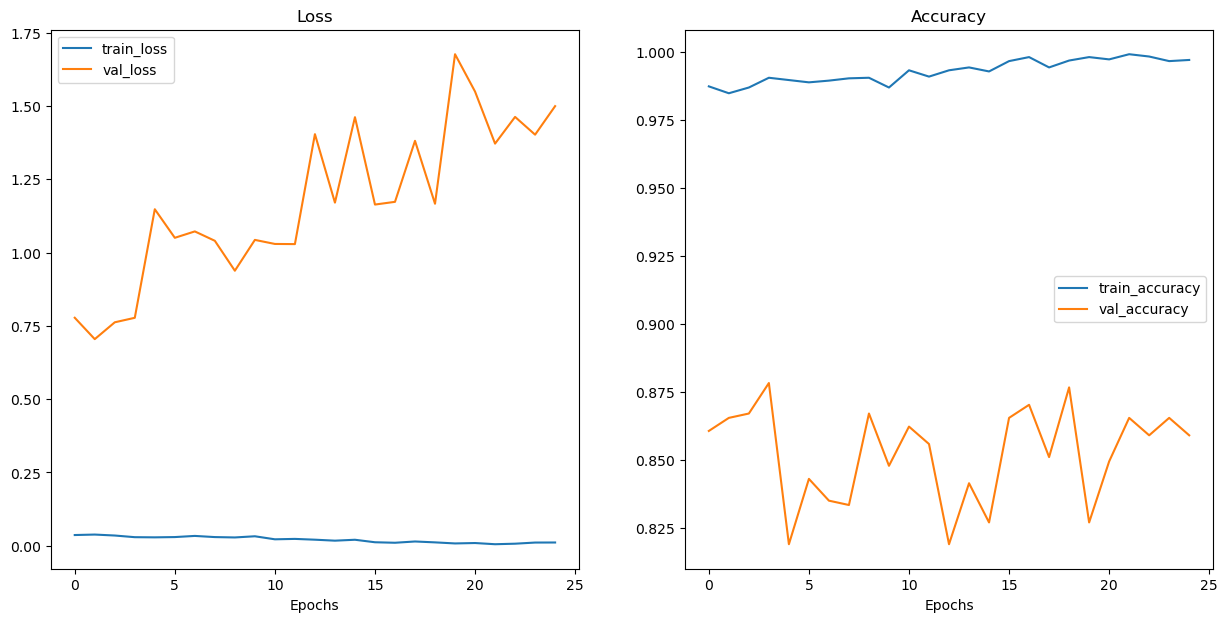

In [59]:
plot_loss_curves(cnn_results)

### 4.4. Aplicação do modelo treinado ao conjunto de teste

In [102]:
""" Função que computa os logits e os labels estimados dado um modelo treinado e um conjunto de amostras de entrada 
"""

def predict_model(model: torch.nn.Module,
                  X: torch.Tensor,
                  task: str,
                  device=device,
                  ):

    # Put model in eval mode
    model.eval() 
  
    # Turn on inference context manager
    with torch.inference_mode():
      
        # Envia os dados para o dispositivo alvo (device)
        X = X.to(device)
        
        #Forward pass
        pred_logits = model(X)
        
        if task == "binary":
            pred_labels = torch.round(torch.sigmoid(pred_logits))
        else:
            pred_labels = torch.argmax(torch.softmax(pred_logits,dim=1))
          
    return pred_logits,pred_labels

Acurácia da rede no conjunto de teste: 87.82%
F1-score da rede no conjunto de teste: 0.911


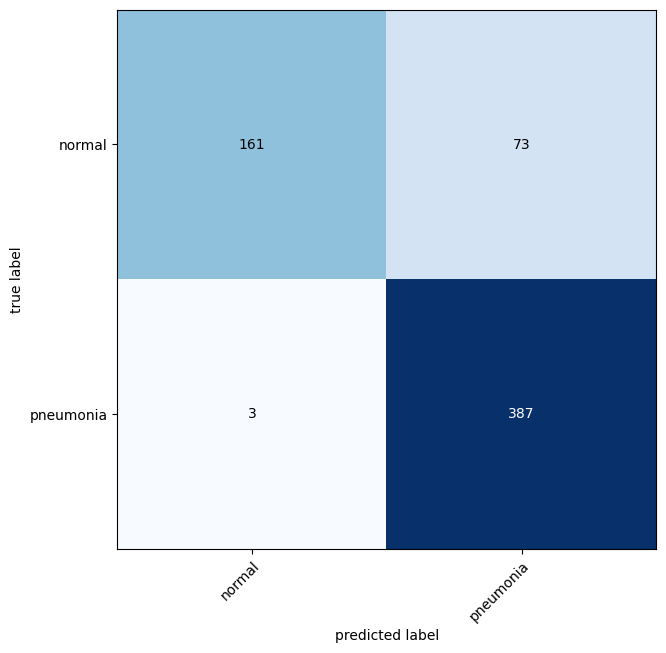

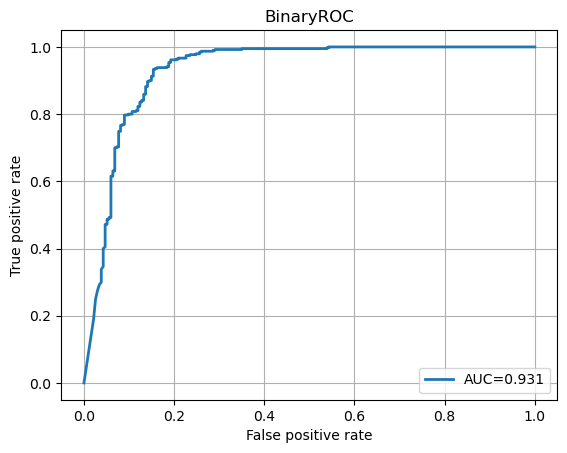

In [103]:
#Obtém os tensores de entrada e saída com o conjunto de teste completo
X_test,y_test = next(iter(test_dataloader))

#Obtém as saídas (logits) da rede treinada para o conjunto de teste e os respectivos labels estimados
cnn_pred_logits_test,cnn_pred_labels_test = predict_model(model=cnn_model, X = X_test, device=device, task="binary")

""" Monta a matriz de confusão 
    Cuidado: todos os tensores e o objeto ConfusionMatrix devem estar no mesmo device
"""
confmat = ConfusionMatrix(num_classes=n_classes, task='binary').to(device)
confmat_tensor = confmat(preds=cnn_pred_logits_test,
                         target=y_test.to(device))

# 3. Exibe a matriz de confusão usando a função do pacote mlxtend
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#Cria métricas e as coloca no mesmo device
torchmetrics_accuracy = Accuracy(task='binary').to(device)
torchmetrics_f1 = F1Score(task='binary').to(device)

#Calculate accuracy
acc_test = torchmetrics_accuracy(preds=cnn_pred_labels_test, target=y_test.to(device))
f1_test = torchmetrics_f1(preds=cnn_pred_labels_test, target=y_test.to(device))
print(f"Acurácia da rede no conjunto de teste: {acc_test*100:.2f}%")
print(f"F1-score da rede no conjunto de teste: {f1_test:.3f}")

""" Curva ROC """
roc_curve = BinaryROC().to(device)
roc_curve.update(preds=torch.sigmoid(cnn_pred_logits_test), target=y_test.to(device))
ax = roc_curve.plot(score=True)


### 4.5. Classificação de amostras aleatórias do conjunto de teste

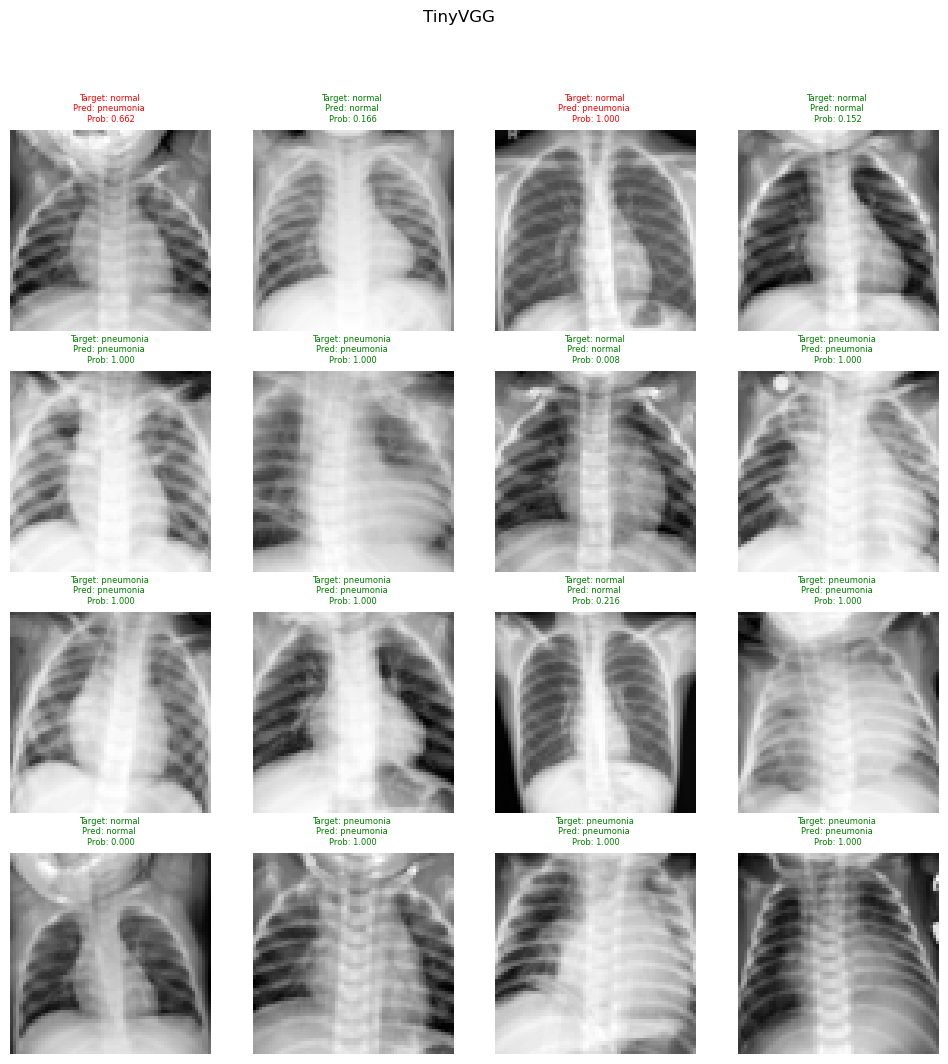

In [107]:
# Vamos exibir 16 figuras aleatórias da base de dados

fig = plt.figure(figsize=(12, 12))
rows, cols = 4, 4

for i in range(0,rows*cols):

    #sorteia um índice de amostra aleatoriamente
    random_idx = torch.randint(0, len(test_data), size=[1]).item()
    #obtém a imagem e o seu rótulo
    img, label = test_data[random_idx]

    """ obtém os logits e o rótulo predito pela rede treinada 
        Detalhe: temos que acrescentar a dim = 0 (referente ao batch_size) """
    cnn_logits,cnn_pred_label = predict_model(model=cnn_model, X=img.unsqueeze(dim=0),task="binary",device=device)

    fig.add_subplot(rows, cols, i+1)

    #exibe a imagem
    plt.imshow(img.squeeze(), cmap="gray")

    #formata o título para exibir o nome da classe estimada e a probabilidade associada 
    nome_classe_estim = class_names[cnn_pred_label.type(torch.int).cpu().item()]

    title = f"Target: {class_names[label.item()]} \nPred: {nome_classe_estim} \nProb: {torch.sigmoid(cnn_logits).cpu().item():.3f}"

    if cnn_pred_label.item() == label.item(): 
        plt.title(title,fontdict={"fontsize": 6, "color": 'g'})
    else:
        plt.title(title,fontdict={"fontsize": 6, "color": 'r'})
    plt.suptitle("TinyVGG")
    plt.axis(False);


## 5. MiniResNet: Treinamento / Validação

### 5.1. Preparação do modelo e treinamento

In [62]:
#Fixa a semente
torch.manual_seed(42)

#Cria uma instância da TinyVGG 
resnet_model = MiniResNet(input_shape=1,
                       base_kernel_units=8,
                       output_shape=1).to(device)

#Cria uma entrada aleatória com o shape esperado - (batch_size, channels, height, width)
#dummy_input = torch.rand((1,1,64,64))

#alimenta o modelo com a entrada para verificar a dimensão na entrada da parte 'classifier'
#model_0(dummy_input.to(device=device))

#exibe o resumo da arquitetura criada
summary(resnet_model, input_size=(1, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
MiniResNet                               [1, 1]                    --
├─Sequential: 1-1                        [1, 8, 16, 16]            --
│    └─Conv2d: 2-1                       [1, 8, 32, 32]            208
│    └─BatchNorm2d: 2-2                  [1, 8, 32, 32]            16
│    └─ReLU: 2-3                         [1, 8, 32, 32]            --
│    └─MaxPool2d: 2-4                    [1, 8, 16, 16]            --
├─Sequential: 1-2                        [1, 8, 16, 16]            --
│    └─Conv2d: 2-5                       [1, 8, 16, 16]            584
│    └─BatchNorm2d: 2-6                  [1, 8, 16, 16]            16
│    └─ReLU: 2-7                         [1, 8, 16, 16]            --
├─Sequential: 1-3                        [1, 8, 16, 16]            --
│    └─Conv2d: 2-8                       [1, 8, 16, 16]            584
│    └─BatchNorm2d: 2-9                  [1, 8, 16, 16]            16
├─ReLU: 1-4 

### 5.2 Loss, Optimizer e Execução do loop de treinamento

In [63]:
#Classificação binária: entropia cruzada - BCEWithLogitsLoss
loss_fn = nn.BCEWithLogitsLoss()

#Algoritmo de otimização
optimizer = torch.optim.Adam(params=resnet_model.parameters(), lr=0.001)


# Define as random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Define o número máximo de épocas de treinamento
NUM_EPOCHS = 100

# Define a paciência (Early stopping)
PATIENCE = 20

# Define o caminho e o nome do arquivo que conterá os pesos/parâmetros salvos do modelo
MODEL_PATH = Path("models/")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "MiniResNet_pneumoniaMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Define a métrica de avaliação adicional a ser monitorada/computada durante o treinamento
acc_metric = Accuracy(task='binary').to(device)


# Inicializa o temporizador
from timeit import default_timer as timer 
start_time = timer()

# Treinamento da CNN
resnet_results = train(model=resnet_model, 
                    train_dataloader=train_dataloader,
                    val_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn, 
                    epochs=NUM_EPOCHS,
                    patience=PATIENCE,
                    model_save_path=MODEL_SAVE_PATH,
                    device=device,
                    metric=acc_metric)

# Encerra o temporizados e mede quanto tempo levou o treinamento completo 
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 0.2788 | train_acc: 0.8963 | val_loss: 0.3160 | val_acc: 0.8686
Epoch: 1 | train_loss: 0.1695 | train_acc: 0.9381 | val_loss: 2.3977 | val_acc: 0.4391
Epoch: 2 | train_loss: 0.1343 | train_acc: 0.9510 | val_loss: 0.6962 | val_acc: 0.7404
Epoch: 3 | train_loss: 0.1149 | train_acc: 0.9546 | val_loss: 0.5348 | val_acc: 0.8093
Epoch: 4 | train_loss: 0.1177 | train_acc: 0.9603 | val_loss: 0.8983 | val_acc: 0.6939
Epoch: 5 | train_loss: 0.1047 | train_acc: 0.9620 | val_loss: 0.2696 | val_acc: 0.8846
Epoch: 6 | train_loss: 0.1030 | train_acc: 0.9620 | val_loss: 0.2202 | val_acc: 0.9167
Epoch: 7 | train_loss: 0.0889 | train_acc: 0.9685 | val_loss: 0.5192 | val_acc: 0.7885
Epoch: 8 | train_loss: 0.0825 | train_acc: 0.9713 | val_loss: 0.3734 | val_acc: 0.8654
Epoch: 9 | train_loss: 0.0699 | train_acc: 0.9747 | val_loss: 0.5585 | val_acc: 0.8109
Epoch: 10 | train_loss: 0.0715 | train_acc: 0.9732 | val_loss: 0.2884 | val_acc: 0.8862
Epoch: 11 | train_loss: 0.0774 | train_acc

### 5.3. Avaliação do progresso do treinamento

Vamos exibir as curvas da função custo e de acurácia para os conjuntos de treinamento e de validação ao longo das épocas

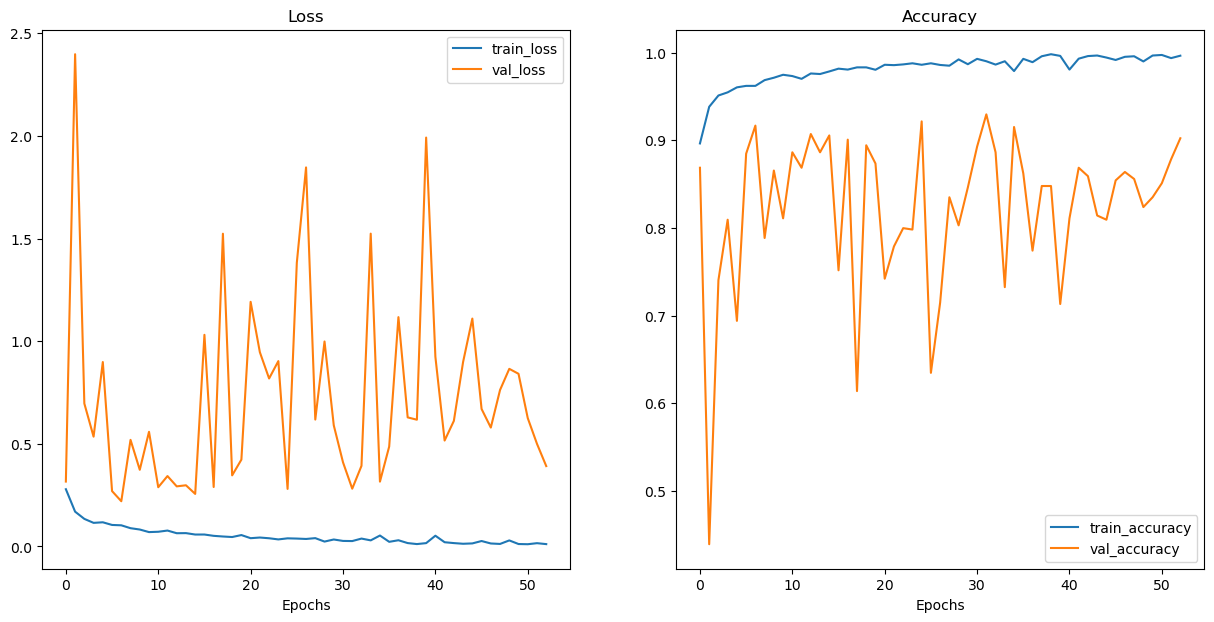

In [64]:
plot_loss_curves(resnet_results)

### 5.4. Aplicação da ResNet treinada ao conjunto de teste

Acurácia da rede no conjunto de teste: 92.95%
F1-score da rede no conjunto de teste: 0.945


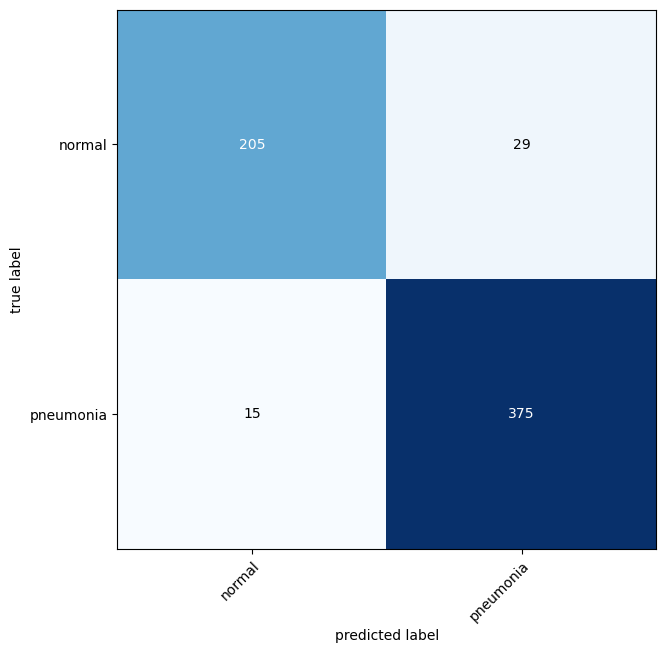

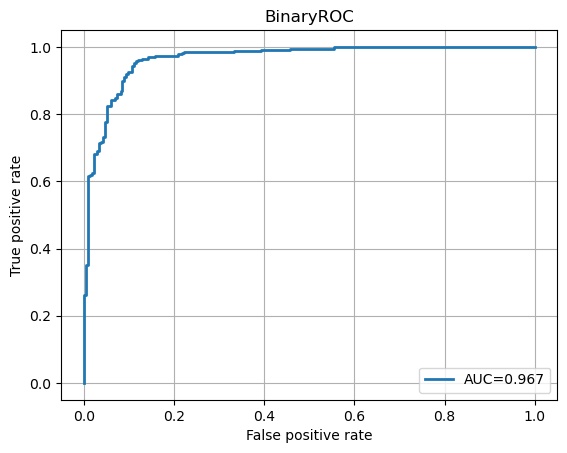

In [69]:
#Obtém os tensores de entrada e saída com o conjunto de teste completo
X_test,y_test = next(iter(test_dataloader))

#Obtém as saídas (logits) da rede treinada para o conjunto de teste e os respectivos labels estimados
resnet_pred_logits_test,resnet_pred_labels_test = predict_model(model=resnet_model, X = X_test, device=device, task="binary")

""" Monta a matriz de confusão 
    Cuidado: todos os tensores e o objeto ConfusionMatrix devem estar no mesmo device
"""
confmat = ConfusionMatrix(num_classes=n_classes, task='binary').to(device)
confmat_tensor = confmat(preds=resnet_pred_logits_test,
                         target=y_test.to(device))

# 3. Exibe a matriz de confusão usando a função do pacote mlxtend
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#Cria métricas e as coloca no mesmo device
torchmetrics_accuracy = Accuracy(task='binary').to(device)
torchmetrics_f1 = F1Score(task='binary').to(device)

#Calculate accuracy
acc_test = torchmetrics_accuracy(preds=resnet_pred_labels_test, target=y_test.to(device))
f1_test = torchmetrics_f1(preds=resnet_pred_labels_test, target=y_test.to(device))
print(f"Acurácia da rede no conjunto de teste: {acc_test*100:.2f}%")
print(f"F1-score da rede no conjunto de teste: {f1_test:.3f}")

""" Curva ROC """
roc_curve = BinaryROC().to(device)
roc_curve.update(preds=torch.sigmoid(resnet_pred_logits_test), target=y_test.to(device))
ax = roc_curve.plot(score=True)


### 5.5. Classificação de amostras do conjunto de teste

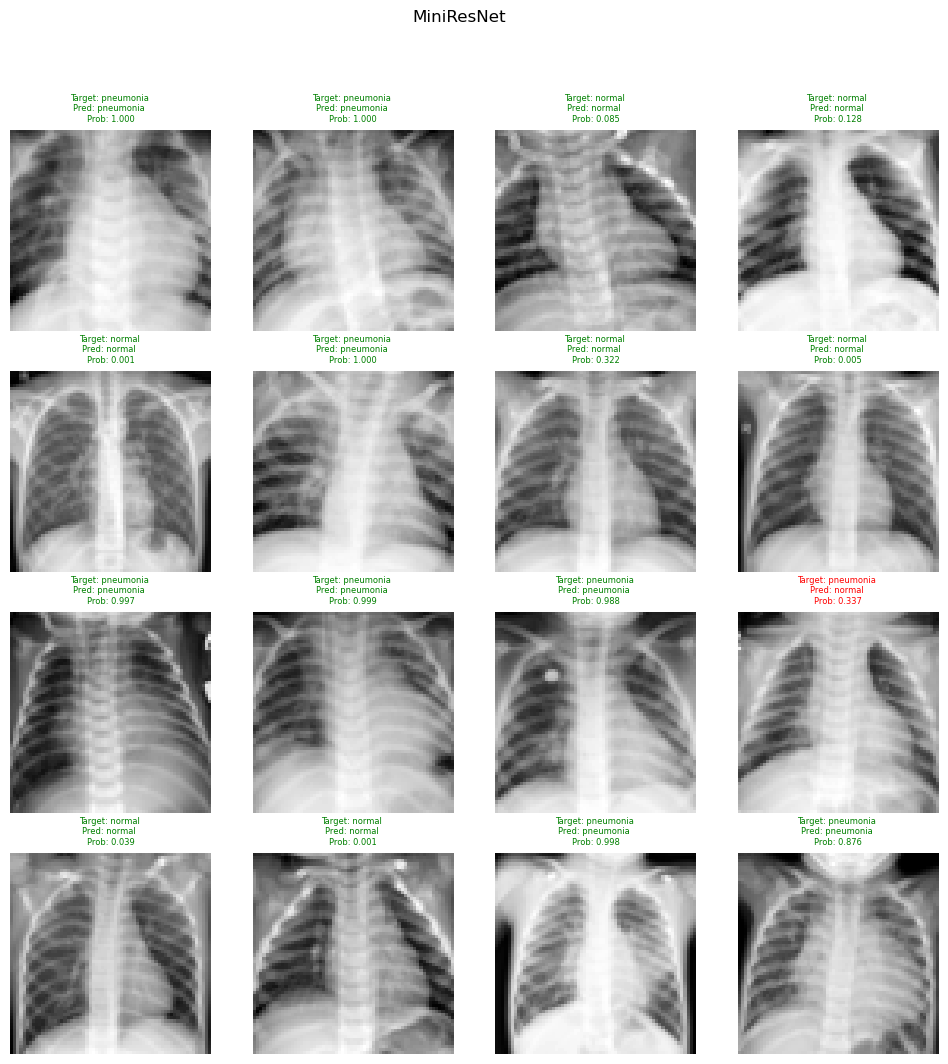

In [108]:
# Vamos exibir 16 figuras aleatórias da base de dados

fig = plt.figure(figsize=(12, 12))
rows, cols = 4, 4

for i in range(0,rows*cols):

    #sorteia um índice de amostra aleatoriamente
    random_idx = torch.randint(0, len(test_data), size=[1]).item()
    #obtém a imagem e o seu rótulo
    img, label = test_data[random_idx]

    """ obtém os logits e o rótulo predito pela rede treinada 
        Detalhe: temos que acrescentar a dim = 0 (referente ao batch_size) """
    resnet_logits,resnet_pred_label = predict_model(model=resnet_model, X=img.unsqueeze(dim=0),task="binary",device=device)

    fig.add_subplot(rows, cols, i+1)

    #exibe a imagem
    plt.imshow(img.squeeze(), cmap="gray")

    #formata o título para exibir o nome da classe estimada e a probabilidade associada 
    nome_classe_estim = class_names[resnet_pred_label.type(torch.int).cpu().item()]

    title = f"Target: {class_names[label.item()]} \nPred: {nome_classe_estim} \nProb: {torch.sigmoid(resnet_logits).cpu().item():.3f}"

    if resnet_pred_label.item() == label.item(): 
        plt.title(title,fontdict={"fontsize": 6, "color": 'g'})
    else:
        plt.title(title,fontdict={"fontsize": 6, "color": 'r'})
    plt.suptitle("MiniResNet")
    plt.axis(False);

